Human Activity Recognition: multiclass classification problem, with 6 actions to predict based on time series & statistical features.

(This is not an autoregressive time series prediction problem!)

Reference:
*   https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
*   https://www.kaggle.com/erenaktas/human-activity-recognition
*   https://www.kaggle.com/code/sylvianclee/human-activity-recognition-cnn-lstm


### Get data

In [ ]:
# https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2022-10-03 05:50:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  33.9MB/s    in 1.7s    

2022-10-03 05:50:52 (33.9 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [ ]:
!unzip -nq 'UCI HAR Dataset.zip'
!ls 'UCI HAR Dataset'

activity_labels.txt  features_info.txt	features.txt  README.txt  test	train


In [ ]:
!cat 'UCI HAR Dataset/activity_labels.txt'

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [ ]:
#!cat 'UCI HAR Dataset/README.txt'

In [ ]:
!ls 'UCI HAR Dataset/train'
!ls 'UCI HAR Dataset/test'

'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt
'Inertial Signals'   subject_test.txt   X_test.txt   y_test.txt


In [ ]:
#!head 'UCI HAR Dataset/train/X_train.txt'
#!head 'UCI HAR Dataset/train/y_train.txt'

In [ ]:
!ls 'UCI HAR Dataset/train/Inertial Signals'
!ls 'UCI HAR Dataset/test/Inertial Signals'

body_acc_x_train.txt  body_gyro_x_train.txt  total_acc_x_train.txt
body_acc_y_train.txt  body_gyro_y_train.txt  total_acc_y_train.txt
body_acc_z_train.txt  body_gyro_z_train.txt  total_acc_z_train.txt
body_acc_x_test.txt  body_gyro_x_test.txt  total_acc_x_test.txt
body_acc_y_test.txt  body_gyro_y_test.txt  total_acc_y_test.txt
body_acc_z_test.txt  body_gyro_z_test.txt  total_acc_z_test.txt


In [ ]:
#!head 'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt'

### Load data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

folder = 'UCI HAR Dataset'
subfolder_t = 'Inertial Signals'

# We use dictionary variables to store train and test data
files_t = dict()
N = dict()  # number of samples
Df = 0      # number of features
Dt = 0      # number of time series
T = 0       # length of time series
K = 0       # number of categories
Y = dict()   # targets
y = dict()   # flattened targets
Xf = dict()  # features
Xt = dict()  # time series

# Import train and test data
for tag in ['train', 'test']:
  subfolder = os.path.join(folder, tag)
  # Load features and targets
  Y[tag] = (pd.read_csv(os.path.join(folder, tag,'y_'+tag+'.txt'), header=None).to_numpy() - 1)
  N[tag] = len(Y[tag])
  y[tag] = Y[tag].flatten()
  Xf[tag] = pd.read_csv(os.path.join(folder, tag,'X_'+tag+'.txt'), delim_whitespace=True, header=None).to_numpy()
  tmp, Df = Xf[tag].shape
  assert(tmp == N[tag])
  print(f'N[{tag}] = {N[tag]}')
  # Load time series: one input file per time series
  subfolder = os.path.join(subfolder, subfolder_t)
  files_t[tag] = sorted(os.listdir(subfolder))  # sort to ensure same order for train and test!
  Dt = len(files_t[tag])
  # Determine shape from input files
  tmp, T = pd.read_csv(os.path.join(subfolder, files_t[tag][0]), delim_whitespace=True, header=None).to_numpy().shape
  assert(tmp == N[tag])
  # Loop through input files
  Xt[tag] = np.zeros((N[tag], T, Dt))
  for d in range(Dt):
    Xt[tag][:,:,d] = pd.read_csv(os.path.join(subfolder, files_t[tag][d]), delim_whitespace=True, header=None).to_numpy()
print(f'Df = {Df}')
print(f'Dt = {Dt} (T = {T})')

# Create split version of Xt for multi-tail models
Xt_split = dict()
for tag in ['train', 'test']:
  Xt_split[tag] = [Xt[tag][:,:,d] for d in range(Dt)]

# Normalize Xf
Xf_scaled = dict()
scaler = StandardScaler()
Xf_scaled['train'] = scaler.fit_transform(Xf['train'])
Xf_scaled['test'] = scaler.transform(Xf['test'])

# Import labels
labels = pd.read_csv(os.path.join(folder, 'activity_labels.txt'), header=None, sep=' ')[1].to_dict()
K = len(labels)
print(f'K = {K} {labels}')

N[train] = 7352
N[test] = 2947
Df = 561
Dt = 9 (T = 128)
K = 6 {0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING'}


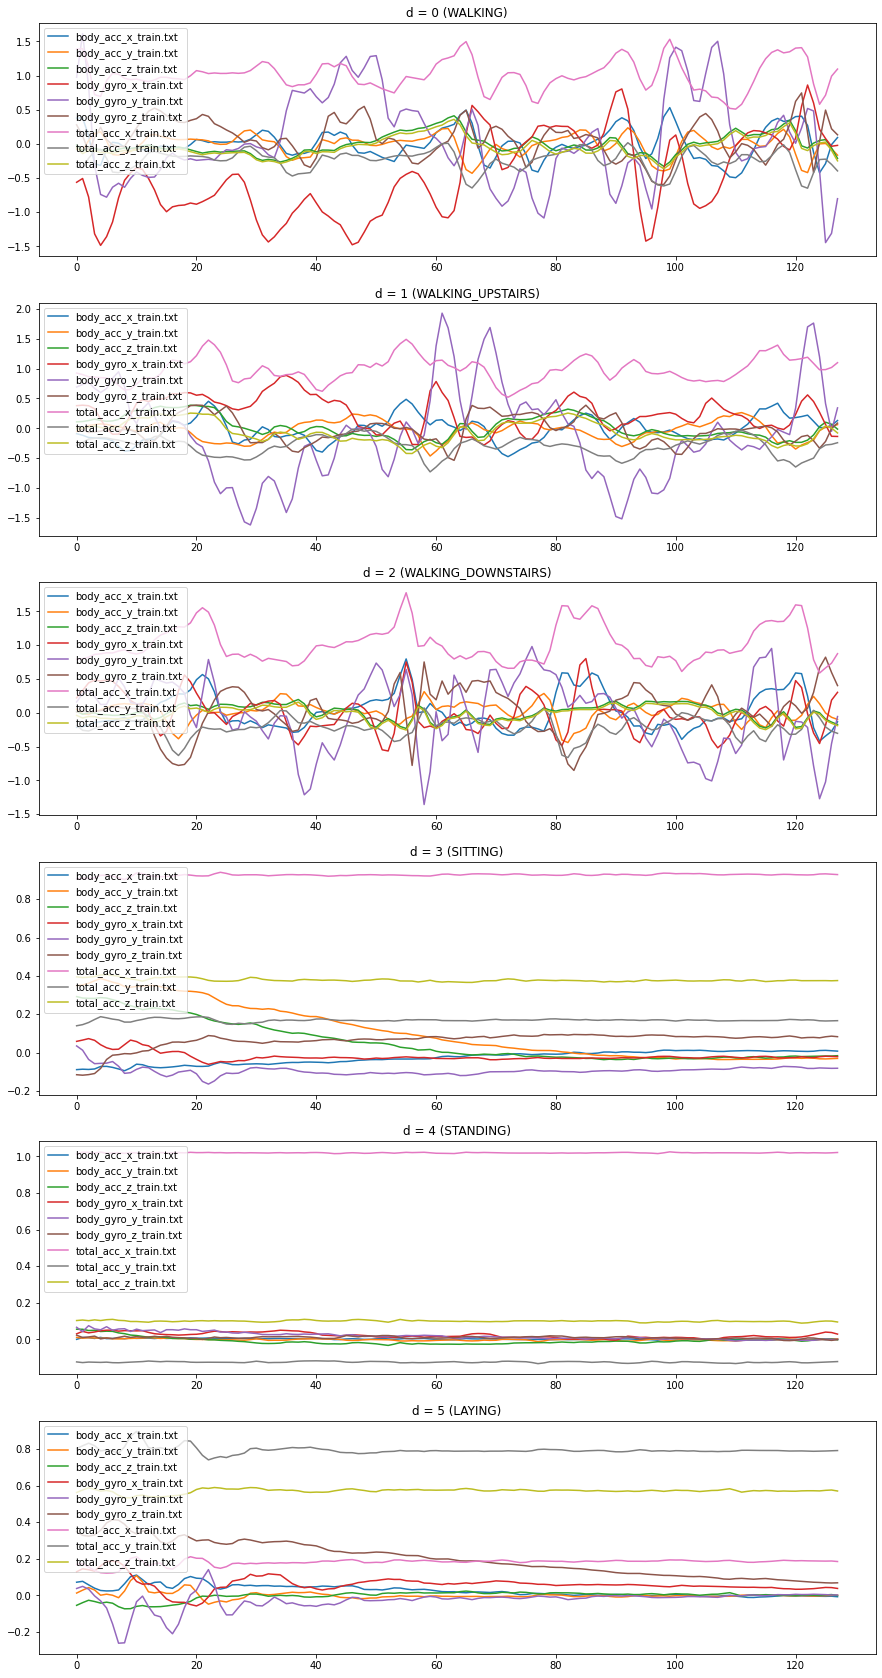

In [ ]:
# Plot the D time series from one sample per category
fig, ax = plt.subplots(nrows=K, figsize=(15,30))
for d in range(K):
  lines = ax[d].plot(Xt['train'][np.where(y['train'] == d)[0][0],:,:]);
  ax[d].legend(lines, files_t['train'], loc='upper left')
  ax[d].set_title(f'd = {d} ({labels[d]})');

### Multi-tail ANN on time series

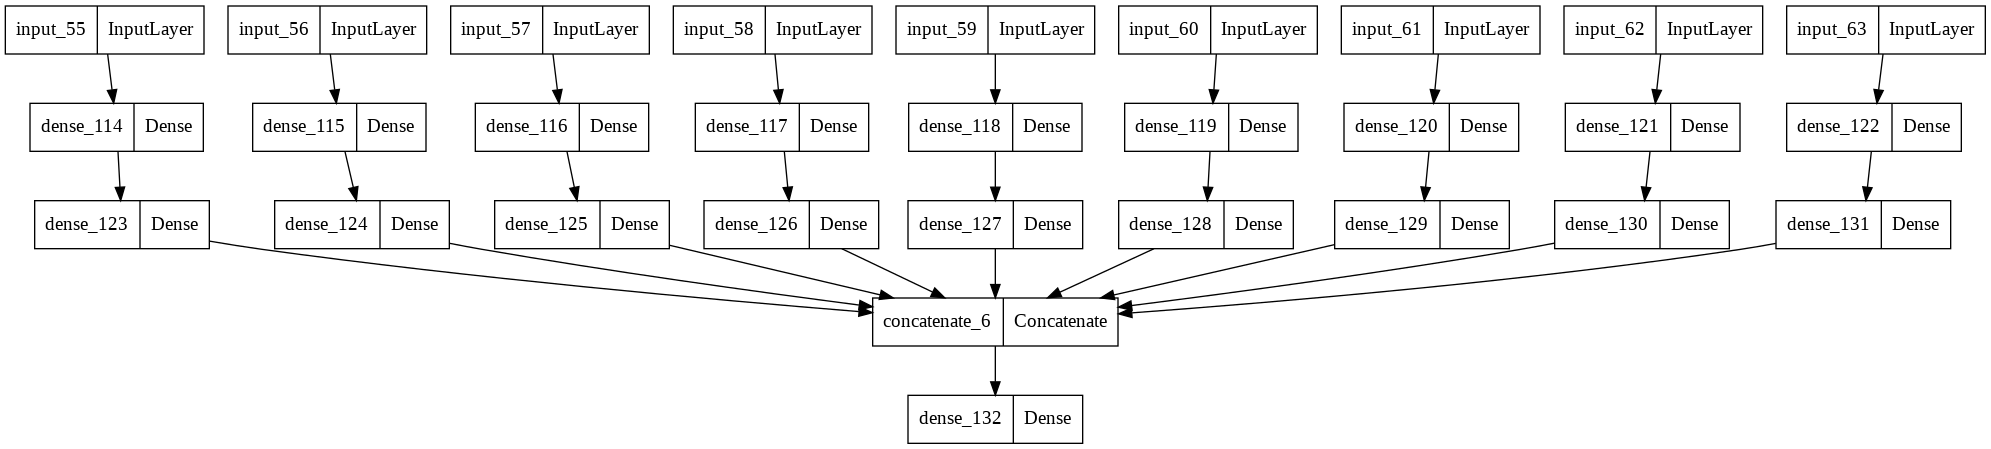

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.utils import plot_model

# The multi-tail ANN is the concatenation of Dt sub-ANN, one per time series
i = [Input(shape=(T,)) for d in range(Dt)]
x = [Dense(32, activation='relu')(i[d]) for d in range(Dt)]
x = [Dense(16, activation='relu')(x[d]) for d in range(Dt)]
x = Concatenate()(x)
x = Dense(K)(x)
model_t = Model(i, x)

plot_model(model_t)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Create checkpoint to retrieve best model
checkpoint_path_t = 'model_t.h5'
checkpoint_t = ModelCheckpoint(
  checkpoint_path_t,
  monitor='val_accuracy',
  save_best_only=True,
  save_weights_only=True
)

# Compile and fit
model_t.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
res_t = model_t.fit(
  Xt_split['train'], y['train'],
  epochs=15,
  validation_data=(Xt_split['test'], y['test']),
  callbacks=[checkpoint_t]
)

# Use best model
model_t.load_weights(checkpoint_path_t)

Epoch 1/15
230/230 [==============================] - 2s 6ms/step - loss: 0.6960 - accuracy: 0.7704 - val_loss: 0.4788 - val_accuracy: 0.8456
Epoch 2/15
230/230 [==============================] - 1s 5ms/step - loss: 0.2270 - accuracy: 0.9242 - val_loss: 0.3601 - val_accuracy: 0.8724
Epoch 3/15
230/230 [==============================] - 1s 6ms/step - loss: 0.1638 - accuracy: 0.9437 - val_loss: 0.3059 - val_accuracy: 0.8789
Epoch 4/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9550 - val_loss: 0.2839 - val_accuracy: 0.8975
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1151 - accuracy: 0.9580 - val_loss: 0.2791 - val_accuracy: 0.8918
Epoch 6/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1033 - accuracy: 0.9610 - val_loss: 0.2844 - val_accuracy: 0.8941
Epoch 7/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0931 - accuracy: 0.9655 - val_loss: 0.2831 - val_accuracy: 0.8968
Epoch 

test acc: 0.9172039362063115



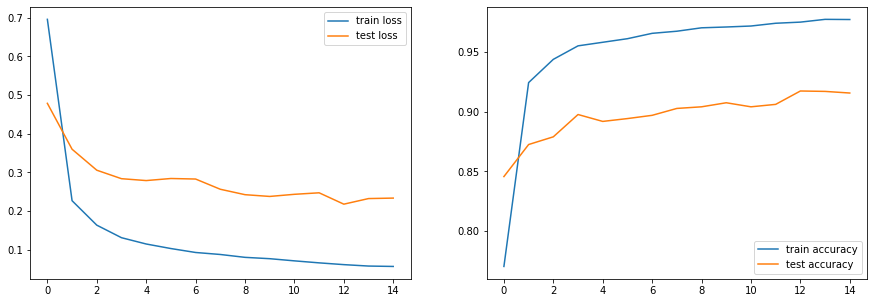

In [ ]:
# Test accuracy
print(f'test acc: {np.mean(np.argmax(model_t.predict(Xt_split["test"]),axis=1) == y["test"])}\n')

# Plot history
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(res_t.history['loss'], label='train loss')
ax[0].plot(res_t.history['val_loss'], label='test loss')
ax[0].legend();
ax[1].plot(res_t.history['accuracy'], label='train accuracy')
ax[1].plot(res_t.history['val_accuracy'], label='test accuracy')
ax[1].legend();

### Basic ANN on features

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Define ANN for input features
i = Input(shape=(Df,))
x = Dense(32, activation='relu')(i)
x = Dense(K)(x)
model_f = Model(i, x)

# Create checkpoint to retrieve best model
checkpoint_path_f = 'model_f.h5'
checkpoint_f = ModelCheckpoint(
  checkpoint_path_f,
  monitor='val_accuracy',
  save_best_only=True,
  save_weights_only=True
)

# Compile and fit
model_f.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
res_f = model_f.fit(
  Xf_scaled['train'], y['train'],
  epochs = 15,
  validation_data=(Xf_scaled['test'], y['test']),
  callbacks=[checkpoint_f]
)

# Use best model
model_f.load_weights(checkpoint_path_f)

Epoch 1/15
230/230 [==============================] - 2s 5ms/step - loss: 0.3287 - accuracy: 0.8772 - val_loss: 0.1748 - val_accuracy: 0.9399
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1063 - accuracy: 0.9612 - val_loss: 0.1771 - val_accuracy: 0.9335
Epoch 3/15
230/230 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9724 - val_loss: 0.1543 - val_accuracy: 0.9399
Epoch 4/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0634 - accuracy: 0.9771 - val_loss: 0.1653 - val_accuracy: 0.9372
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0520 - accuracy: 0.9831 - val_loss: 0.1606 - val_accuracy: 0.9413
Epoch 6/15
230/230 [==============================] - 1s 2ms/step - loss: 0.0443 - accuracy: 0.9856 - val_loss: 0.1885 - val_accuracy: 0.9352
Epoch 7/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0412 - accuracy: 0.9856 - val_loss: 0.1706 - val_accuracy: 0.9389
Epoch 

test acc: 0.9487614523243977



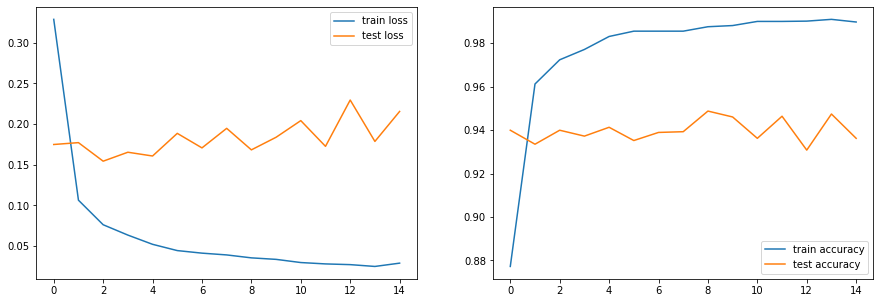

In [ ]:
# Test accuracy
print(f'test acc: {np.mean(np.argmax(model_f.predict(Xf_scaled["test"]),axis=1) == y["test"])}\n')

# Plot history
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(res_f.history['loss'], label='train loss')
ax[0].plot(res_f.history['val_loss'], label='test loss')
ax[0].legend();
ax[1].plot(res_f.history['accuracy'], label='train accuracy')
ax[1].plot(res_f.history['val_accuracy'], label='test accuracy')
ax[1].legend();

### ANN combined model

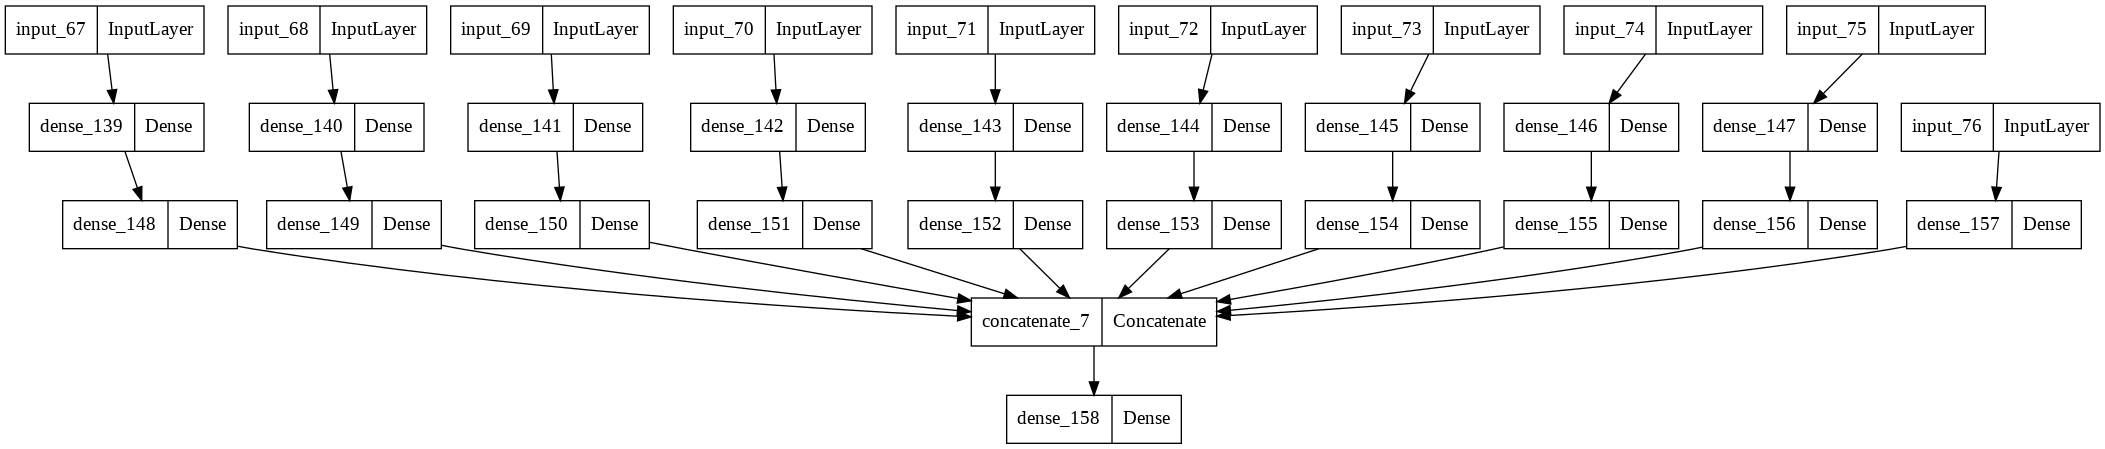

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.utils import plot_model

# We combine the multi-tail ANN model with Dt sub-ANN, and the basic ANN model
i = [Input(shape=(T,)) for d in range(Dt)]
x = [Dense(32, activation='relu')(i[d]) for d in range(Dt)]
x = [Dense(16, activation='relu')(x[d]) for d in range(Dt)]

i2 = Input(shape=(Df,))
x2 = Dense(32, activation='relu')(i2)

x = Concatenate()(x + [x2])
x = Dense(K)(x)
model = Model(i + [i2], x)

plot_model(model)

In [ ]:
# Create checkpoint to retrieve best model
checkpoint_path = 'model.h5'
checkpoint = ModelCheckpoint(
  checkpoint_path,
  monitor='val_accuracy',
  save_best_only=True,
  save_weights_only=True
)

# Combine input
X = dict()
for tag in ['train', 'test']:
  X[tag] = Xt_split[tag] + [Xf_scaled[tag]]

# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
res = model.fit(
  X['train'], y['train'],
  epochs = 15,
  validation_data=(X['test'], y['test']),
  callbacks=[checkpoint]
)

# Use best model
model.load_weights(checkpoint_path)

Epoch 1/15
230/230 [==============================] - 3s 7ms/step - loss: 0.3208 - accuracy: 0.8832 - val_loss: 0.2805 - val_accuracy: 0.8992
Epoch 2/15
230/230 [==============================] - 1s 6ms/step - loss: 0.1018 - accuracy: 0.9646 - val_loss: 0.2012 - val_accuracy: 0.9294
Epoch 3/15
230/230 [==============================] - 1s 6ms/step - loss: 0.0685 - accuracy: 0.9755 - val_loss: 0.1599 - val_accuracy: 0.9410
Epoch 4/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0517 - accuracy: 0.9822 - val_loss: 0.1853 - val_accuracy: 0.9365
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0458 - accuracy: 0.9842 - val_loss: 0.1939 - val_accuracy: 0.9318
Epoch 6/15
230/230 [==============================] - 1s 6ms/step - loss: 0.0421 - accuracy: 0.9846 - val_loss: 0.1845 - val_accuracy: 0.9396
Epoch 7/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0378 - accuracy: 0.9869 - val_loss: 0.1347 - val_accuracy: 0.9498
Epoch 

test acc: 0.9569053274516457



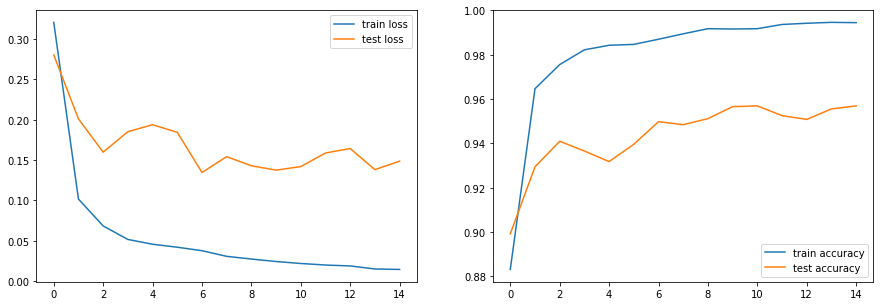

In [ ]:
# Test accuracy
print(f'test acc: {np.mean(np.argmax(model.predict(X["test"]),axis=1) == y["test"])}\n')

# Plot history
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(res.history['loss'], label='train loss')
ax[0].plot(res.history['val_loss'], label='test loss')
ax[0].legend();
ax[1].plot(res.history['accuracy'], label='train accuracy')
ax[1].plot(res.history['val_accuracy'], label='test accuracy')
ax[1].legend();

### Compare against Linear Regression, Random Forest, SVC (on features)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

models = [
  LinearRegression(),
  LinearSVC(max_iter=20000),
  SVC(),
  RandomForestClassifier()
]

# Fit and score
for model in models:
  model.fit(Xf_scaled['train'], y['train'])
  print(f'{str(model)} - train accuracy: {model.score(Xf_scaled["train"], y["train"]):.2f}')
  print(f'{str(model)} - test  accuracy: {model.score(Xf_scaled["test"], y["test"]):.2f}')
  print()

LinearRegression() - train accuracy: 0.98
LinearRegression() - test  accuracy: 0.95

LinearSVC(max_iter=20000) - train accuracy: 1.00
LinearSVC(max_iter=20000) - test  accuracy: 0.97

SVC() - train accuracy: 0.99
SVC() - test  accuracy: 0.95

RandomForestClassifier() - train accuracy: 1.00
RandomForestClassifier() - test  accuracy: 0.93

